## Example 01 - Basic simulation - consumes energy
In this notebook, we are going to make a simulation which forces a vessel to move over a certain 1D waterway network. It tries to give one an understanding of the most basic core functions of OpenTNSim and teach one the requirements to set-up a basic OpenTNSim model run. 

We add some properties to the graph (depth) and the vessel (VesselProperties, HasContainer, ConsumesEnergy) in order to calculate resistance, required power, 

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

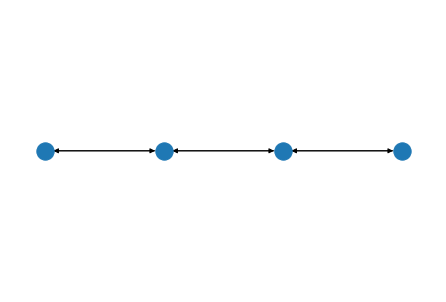

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1

for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 4})
    
# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 4
General depth for edge ('Node 2', 'Node 3') is 4
General depth for edge ('Node 2', 'Node 1') is 4
General depth for edge ('Node 3', 'Node 4') is 4
General depth for edge ('Node 3', 'Node 2') is 4
General depth for edge ('Node 4', 'Node 3') is 4


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type('Vessel', 
                         (opentnsim.core.Identifiable, 
                          opentnsim.core.Movable, 
                          opentnsim.core.Routeable,
                          opentnsim.core.VesselProperties,     # needed to add vessel properties
                          opentnsim.core.HasContainer,         # needed to calculate filling degree for draught
                          opentnsim.core.ConsumesEnergy), {})  # needed to calculate resistances            

In [5]:
# Create a dict with all important settings
data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 4.16,  # m/s
               "type": 'Dortmund-Eems (L <= 74 m)', # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4, 
               "L": 110,
               "ukc":0,  #under keel clearance, depends on river bed, cargo type and shippers choice
               "vesl_type": "Dry",  #  should be "Container","Dry","Barge" or "Tanker"'
               "capacity": 2500,   # maximum designed payload
               "level": 2500,     # actual payload
               "H_e": None, 
               "H_f": None, 
               "P_installed": 1750.0, 
               "L_w": 3.0, 
               "C_b": 0.85,
               "c_year":1990,
               "current_year":None
              }               

vessel = TransportResource(**data_vessel)

### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [6]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [7]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessel.env = env                                        #the created environment
vessel.name = 'Vessel No.1'                     
vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)

# Start the simulation
env.process(vessel.move())
env.run()

### Output
We can now analyse the output of the simulation, which consists of the log-file of the vessel. We got this log-file as we added the log mix-in of OpenTNSim. This log-file keeps track of the moving activities of the vessel, and at which time and location they occur. The log-file could also keep track of an additional value, such as waiting times, which are not included here in this simulation.

As you can see, the vessel moves from its origin (*Node 1*) to its destination (*Node 4*) by passing *Node 2* and *Node 3* respectively. The time is calculated by the greater circle distance between the nodes, divided by the speed of the vessel.

Using this log-file, we could for example plot a time-distance graph.

In [8]:
df = pd.DataFrame.from_dict(vessel.log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node 1 to node Node 2 start,2021-05-27 22:47:38.000000,0,POINT (0 0)
1,Sailing from node Node 1 to node Node 2 stop,2021-05-28 05:28:16.052543,0,POINT (0.8983 0)
2,Sailing from node Node 2 to node Node 3 start,2021-05-28 05:28:16.052543,0,POINT (0.8983 0)
3,Sailing from node Node 2 to node Node 3 stop,2021-05-28 12:08:54.105086,0,POINT (1.7966 0)
4,Sailing from node Node 3 to node Node 4 start,2021-05-28 12:08:54.105086,0,POINT (1.7966 0)
5,Sailing from node Node 3 to node Node 4 stop,2021-05-28 18:49:32.157629,0,POINT (2.6949 0)


### Post processing: calculate energy consumptions and emissions

In [9]:
# create an EnergyCalculation object (graph FG and vessel are needed as input)
energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)

In [10]:
# we can now work out in hindsight what resistance, power, energy and emissions were generated
energycalculation.calculate_energy_consumption()

# ToDo:
# - perhaps add to the printstatements which edge is sailed 
# - may be the print statements can be cleaned up (fewer significant digits)
# - possibly even make it optional to print this, because the next cells show dataframes with the output
# - etc

delta_t: 24038.0525 s
distance: 99998.2986 m
velocity: 4.1600 m/s


NameError: name 'h' is not defined

In [ ]:
df = pd.DataFrame.from_dict(energycalculation.energy_use)
df['CO2_g_km'] = df['total_emission_CO2'] / df['distance']*1000
df['PM10_g_km'] = df['total_emission_PM10'] / df['distance']*1000
df['NOX_g_km'] = df['total_emission_NOX'] / df['distance']*1000
df['diesel_kg_km'] = df['total_energy'] *0.225/ df['distance']*1000 
df.head()

In [ ]:
# amount=30000 #ton
# payload=500 #ton
# distance_oneTrip=600 #km
# # Unload_return:diesel:25.5kg/km CO2:79221g/km, PM10: 44 g/km,NOx:1111 g/km 
# distance_total=amount/payload*distance_oneTrip  #km total distance
# CO2_total=0.5*distance_total*(df['CO2_g_km']+79221)/1000  #Kg
# PM10_total=0.5*distance_total*(df['PM10_g_km']+44)/1000  #Kg
# NOx_total=0.5*distance_total*(df['NOX_g_km']+1111)/1000  #Kg
# diesel_total=0.5*distance_total*(df['diesel_kg_km']+25.5)    # kg in total trips

# print('the toatal CO2 EMISSION of',payload,'payload strategy is',CO2_total)
# print('the toatal PM10 EMISSION of',payload,'payload strategy is',PM10_total)
# print('the toatal NOx EMISSION of',payload,'payload strategy is',NOx_total)
# print('the toatal diesel consumption of',payload,'payload strategy is',diesel_total)
# print('the toatal distance of',payload,'payload strategy is',distance_total)


In [ ]:
diesel_total=300*df['diesel_kg_km'] #kg
CO2_total=300*df['CO2_g_km']/1000  #kg
PM10_total=300*df['PM10_g_km']  #g
NOx_total=300*df['NOX_g_km']/1000    #kg

print('the toatal diesel consumption ',diesel_total)
print('the toatal CO2 EMISSION ',CO2_total)
print('the toatal PM10 EMISSION ',PM10_total)
print('the toatal NOx EMISSION',NOx_total)